# Federated Learning Example - Metrics and Plots - Automobile Dataset

In [1]:
import numpy as np
import pandas as pd
import random
from pathlib import Path
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model as tf_load_model

# difference with previous: imports of eval_metrics
from src.tf_utils import df_to_tfds
from src.data_examples.ex1_data_loader import ExampleDataLoader


## Copies from learning notebook but just the essentials

In [2]:
# globals const

RAND_SEED   = 1337

# global vars

saved_model_path = Path('saved_models')
metrics_csv_path = Path('metrics')

## Fetch model names and its corresponding metrics and models

In [3]:
def emit_model_name_prefix_meta(model_name: str, sep=' '):
  return sep.join(model_name.split('_')[3:])

In [4]:
model_names = []

with open('saved_model_names.txt', 'r') as fo:
  model_names = list(map(lambda x: x.strip(),fo.readlines()))

model_names

['ex1ch1_auto_classifier_centralized',
 'ex1ch1_auto_classifier_federated_ensemble_n5',
 'ex1ch1_auto_classifier_federated_ensemble_n10',
 'ex1ch1_auto_classifier_federated_ensemble_n15',
 'ex1ch1_auto_classifier_federated_ensemble_n20']

In [5]:
model_metrics_csv_files = {}
model_trained_folders = {}

for model_name in model_names:

  csv_files = metrics_csv_path.rglob(f'{model_name}_*.csv')
  model_metrics_csv_files[model_name] = list(csv_files)

  model_folders = saved_model_path.rglob(f'{model_name}*')
  model_trained_folders[model_name] = list(model_folders)

model_trained_folders

{'ex1ch1_auto_classifier_centralized': [WindowsPath('saved_models/ex1ch1_auto_classifier_centralized')],
 'ex1ch1_auto_classifier_federated_ensemble_n5': [WindowsPath('saved_models/ex1ch1_auto_classifier_federated_ensemble_n5_0'),
  WindowsPath('saved_models/ex1ch1_auto_classifier_federated_ensemble_n5_1'),
  WindowsPath('saved_models/ex1ch1_auto_classifier_federated_ensemble_n5_2'),
  WindowsPath('saved_models/ex1ch1_auto_classifier_federated_ensemble_n5_3'),
  WindowsPath('saved_models/ex1ch1_auto_classifier_federated_ensemble_n5_4')],
 'ex1ch1_auto_classifier_federated_ensemble_n10': [WindowsPath('saved_models/ex1ch1_auto_classifier_federated_ensemble_n10_0'),
  WindowsPath('saved_models/ex1ch1_auto_classifier_federated_ensemble_n10_1'),
  WindowsPath('saved_models/ex1ch1_auto_classifier_federated_ensemble_n10_2'),
  WindowsPath('saved_models/ex1ch1_auto_classifier_federated_ensemble_n10_3'),
  WindowsPath('saved_models/ex1ch1_auto_classifier_federated_ensemble_n10_4'),
  WindowsPat

## 1. Training Metrics

In [6]:
training_dfs_ls = {}

for model_name, ls in model_metrics_csv_files.items():
  training_dfs_ls[model_name] = []

  for path in ls:
    training_dfs_ls[model_name].append(pd.read_csv(path))

# uncomment to inspec
# training_dfs_ls

Merge loaded dataframe with mean aggregation if multiple dataframe is present

Since federated model consist of multiple client, metrics is (assumed) aggregated with mean

In [7]:
training_dfs_mean = {}

for model_name, ls in training_dfs_ls.items():
  concat = pd.concat(ls)
  c_group = concat.groupby(concat.index).mean()

  training_dfs_mean[model_name] = c_group

# uncomment to inspec
# training_dfs_mean

### Plotting in plt

In [8]:
# check column names if needed

list(training_dfs_mean.values())[0].columns

Index(['epoch', 'loss', 'accuracy', 'mse', 'binary_accuracy', 'val_loss',
       'val_accuracy', 'val_mse', 'val_binary_accuracy'],
      dtype='object')

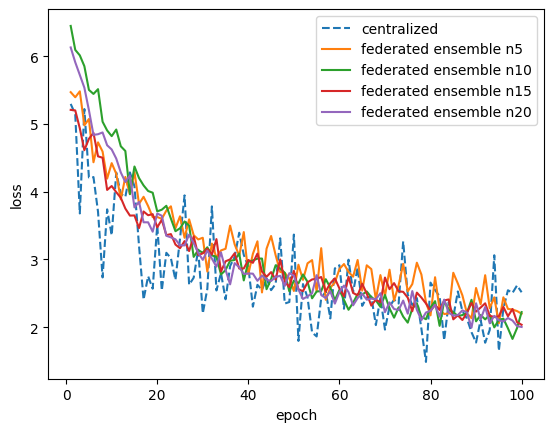

In [9]:
feature_x = 'epoch'
feature_y = 'loss'

fig, ax = plt.subplots()

ax.set_xlabel(feature_x)
ax.set_ylabel(feature_y)
for model_name, df in training_dfs_mean.items():

  model_name = emit_model_name_prefix_meta(model_name)

  if model_name.endswith('centralized'):
    ax.plot(df[feature_x], df[feature_y], label=model_name, linestyle='--')
  else:
    ax.plot(df[feature_x], df[feature_y], label=model_name)

  ax.legend()


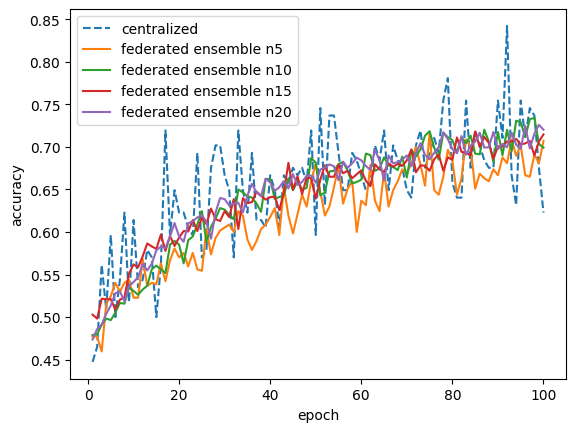

In [10]:
feature_x = 'epoch'
feature_y = 'accuracy'

fig, ax = plt.subplots()

ax.set_xlabel(feature_x)
ax.set_ylabel(feature_y)
for model_name, df in training_dfs_mean.items():

  model_name = emit_model_name_prefix_meta(model_name)

  if model_name.endswith('centralized'):
    ax.plot(df[feature_x], df[feature_y], label=model_name, linestyle='--')
  else:
    ax.plot(df[feature_x], df[feature_y], label=model_name)

  ax.legend()


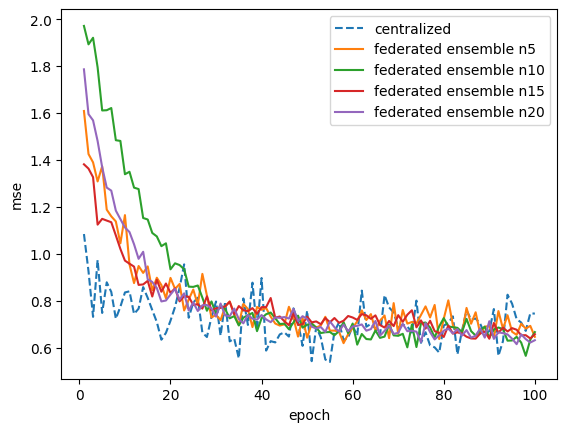

In [11]:
feature_x = 'epoch'
feature_y = 'mse'

fig, ax = plt.subplots()

ax.set_xlabel(feature_x)
ax.set_ylabel(feature_y)
for model_name, df in training_dfs_mean.items():

  model_name = emit_model_name_prefix_meta(model_name)

  if model_name.endswith('centralized'):
    ax.plot(df[feature_x], df[feature_y], label=model_name, linestyle='--')
  else:
    ax.plot(df[feature_x], df[feature_y], label=model_name)

  ax.legend()


## 2. Valuations Metrics

### Federated Model Ensemble Valuators

In [12]:
def fn_eval(model, tfds):
  # valuation for metrics
  return model.evaluate(tfds)

def fn_predict(model, tfds):
  # valuation for prediction
  return model.predict(tfds)

def evaluate_ensemble(models, tfds, fn_valuation, fn_aggregation=np.mean):
  res = []
  for model in models:
    res.append(fn_valuation(model, tfds))
  return fn_aggregation(res, axis=0)


In [13]:
data = ExampleDataLoader()
data.download().load().clean()

data.df['symboling_threshold'] = [1 if i > 0 else 0 for i in data.df['symboling']]

target_feature_label = 'symboling_threshold'

using cached file cache\static\public\10\automobile.zip
extracting zip file content:
 	size: 144	filename: Index
 	size: 1197	filename: app.css
 	size: 25936	filename: imports-85.data
 	size: 4747	filename: imports-85.names
 	size: 3757	filename: misc


In [14]:
__df_main_train_val = data.df.sample(frac=0.9, random_state=RAND_SEED)

df_main_test   = data.df.drop(__df_main_train_val.index)
tfds_main_test = df_to_tfds(df_main_test,  target_feature_label, batch_size=8, shuffle=False)


# ! assert the test dataset index we're using 
# is the same with the train we did in previous notebook

df_main_test 

c:\Users\62896\Documents\GitHub\FederatedLearning\src\tf_utils.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_df = {key: value[:,tf.newaxis] for key, value in df.items()}


,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,symboling_threshold
12,0,188.0,bmw,gas,std,two,sedan,rwd,front,101.199997,...,mpfi,3.31,3.19,9.0,121.0,4250.0,21.0,28.0,20970.0,0
19,1,98.0,chevrolet,gas,std,two,hatchback,fwd,front,94.500000,...,2bbl,3.03,3.11,9.6,70.0,5400.0,38.0,43.0,6295.0,1
33,1,101.0,honda,gas,std,two,hatchback,fwd,front,93.699997,...,1bbl,2.91,3.41,9.2,76.0,6000.0,30.0,34.0,6529.0,1
34,1,101.0,honda,gas,std,two,hatchback,fwd,front,93.699997,...,1bbl,2.91,3.41,9.2,76.0,6000.0,30.0,34.0,7129.0,1
38,0,106.0,honda,gas,std,two,hatchback,fwd,front,96.500000,...,1bbl,3.15,3.58,9.0,86.0,5800.0,27.0,33.0,9095.0,0
102,0,108.0,nissan,gas,std,four,wagon,fwd,front,100.400002,...,mpfi,3.43,3.27,9.0,152.0,5200.0,17.0,22.0,14399.0,0
116,0,161.0,peugot,diesel,turbo,four,sedan,rwd,front,107.900002,...,idi,3.70,3.52,21.0,95.0,4150.0,28.0,33.0,17950.0,0
118,1,119.0,plymouth,gas,std,two,hatchback,fwd,front,93.699997,...,2bbl,2.97,3.23,9.4,68.0,5500.0,37.0,41.0,5572.0,1
125,3,186.0,porsche,gas,std,two,hatchback,rwd,front,94.500000,...,mpfi,3.94,3.11,9.5,143.0,5500.0,19.0,27.0,22018.0,1
133,2,104.0,saab,gas,std,four,sedan,fwd,front,99.099998,...,mpfi,3.54,3.07,9.3,110.0,5250.0,21.0,28.0,12170.0,1


Load saved models to this notebook

In [15]:
trained_model_ls = {}

for model_name, ls in model_trained_folders.items():
  trained_model_ls[model_name] = []

  for path in ls:
    trained_model_ls[model_name].append(tf_load_model(path))



In [16]:
# uncomment to inspec
# trained_model_ls

### Note

the model metrics from training notebook consists of:
- Loss
- Accuracy
- MSE
- Binary Accuracy

and since models are stored in dict\[list\], ensemble evaluation does not affect centralized model (list length of 1) 

In [17]:
metrics_names = ['Loss' ,'Accuracy' ,'MSE' ,'Binary Accuracy']

In [18]:
trained_model_inference_results = {}

for model_name, model_ls in trained_model_ls.items():
  trained_model_inference_results[model_name] = evaluate_ensemble(model_ls, tfds_main_test, fn_eval)

C:\Users\62896\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py:639: UserWarning: Input dict contained keys ['symboling', 'normalized_losses', 'symboling_threshold'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


2/2 [==============================] - 0s 5ms/step - loss: 1.1697 - accuracy: 0.7500 - mse: 0.3069 - binary_accuracy: 0.7500


In [19]:
trained_model_inference_results

{'ex1ch1_auto_classifier_centralized': array([1.25545025, 0.8125    , 0.34822559, 0.8125    ]),
 'ex1ch1_auto_classifier_federated_ensemble_n5': array([0.84334632, 0.825     , 0.25366568, 0.825     ]),
 'ex1ch1_auto_classifier_federated_ensemble_n10': array([0.95806748, 0.8375    , 0.32656849, 0.8375    ]),
 'ex1ch1_auto_classifier_federated_ensemble_n15': array([0.97439092, 0.84583333, 0.25500637, 0.84583333]),
 'ex1ch1_auto_classifier_federated_ensemble_n20': array([0.93878307, 0.828125  , 0.27269997, 0.828125  ])}

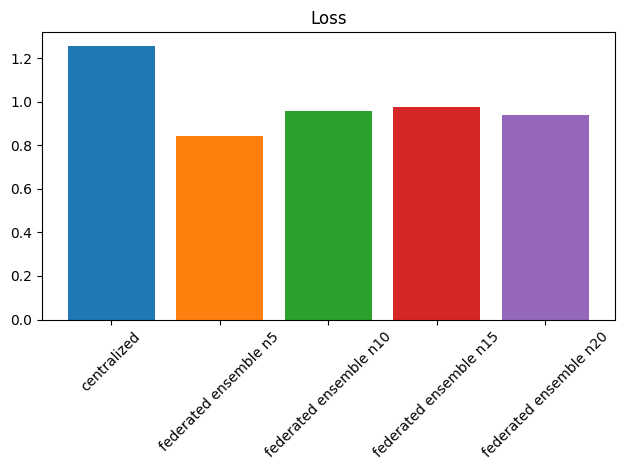

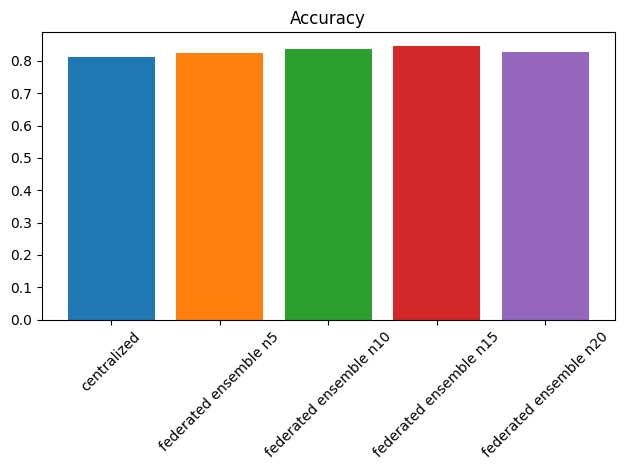

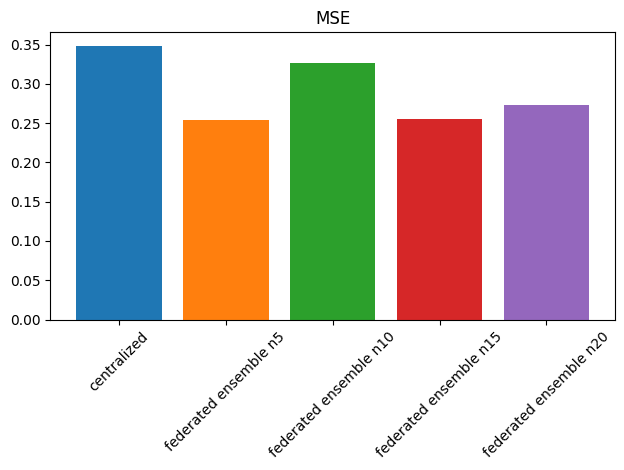

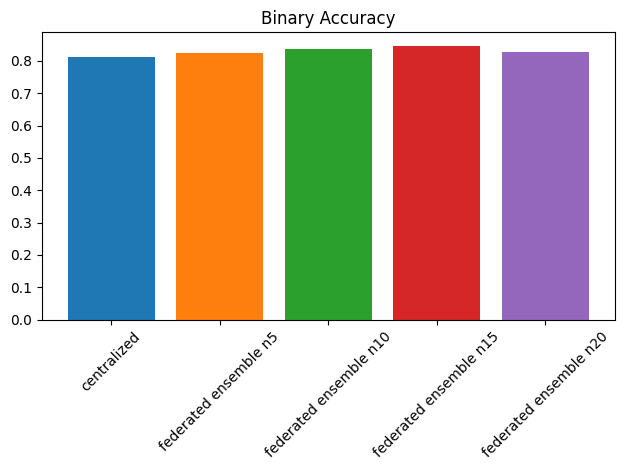

In [20]:

for n, metric in enumerate(metrics_names):
  for model_name, res in trained_model_inference_results.items():
    model_name = emit_model_name_prefix_meta(model_name)
    plt.bar(model_name, res[n])
    plt.xticks(rotation=45)
    plt.title(metric)
  plt.tight_layout()
  plt.show()